In [253]:
# Importation des bibliothèques nécessaires
import pandas as pd  # Manipulation de données
import numpy as np  # Calculs numériques
import matplotlib.pyplot as plt  # Visualisation de données
import seaborn as sns  # Visualisation avancée

# Importation des bibliothèques de scikit-learn pour la modélisation
from sklearn.model_selection import train_test_split  # Division des données en ensembles d'entraînement et de test
from sklearn.ensemble import RandomForestClassifier  # Modèle de classification Random Forest
from sklearn.linear_model import LinearRegression  # Modèle de régression linéaire
from sklearn.pipeline import make_pipeline  # Construction de pipelines pour le prétraitement et les modèles
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # Normalisation et transformation polynomiale
from sklearn.decomposition import PCA  # Réduction de dimension avec PCA
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error  # Évaluation des modèles

# Import des outils de scikit-learn nécessaires
from sklearn.model_selection import GridSearchCV  # Optimisation des hyperparamètres
from sklearn.metrics import roc_auc_score, roc_curve  # Évaluation avec AUC-ROC
from sklearn.model_selection import cross_val_score


# Acquisition des données

In [254]:
# Define data path and folder
path_phone = "C:/Users/scoup/Downloads/arrow_data_psyn.csv"
df = pd.read_csv(path_phone, on_bad_lines='skip')


In [255]:
df.shape

(7580, 16)

In [256]:
df

,Reference ZENER,Stock,Fabricant,Type,Configuration,0minal Zener Voltage (V),Zener volatge tolerance,Maximum power dissipation (MW),Test Current (MA),Maximum reverse leaking current (UA),Maximum regulator current (MA),Maximum Zener impedance (OHM),Maximum power dissipation (MW,Packaging,Pin Count,SVHC
0,TZMC1V0-GS08 Zener Diode S1 0.75V 7% 8Ohm 500m...,NaN,18,V,S1,0.75,7%,500.0,5.00,NaN,NaN,8,500.0,7.0,2.0,0.0
1,TZMC1V0-M-08 Zener Diode S1 0.75V 7% 8Ohm 500m...,NaN,18,V,S1,0.75,7%,500.0,5.00,NaN,NaN,8(Typ),500.0,7.0,2.0,0.0
2,BZX8850S-C1V8YL Zener Diode S1 1.8V 5% 100Ohm ...,NaN,11,V,S1,1.80,5%,365.0,0.05,7.5,NaN,100,365.0,7.0,2.0,1.0
3,JANS1N4614DUR-1 Diode Zener S1 1.8V 1% 500mW 2...,NaN,10,V,S1,1.80,1%,500.0,0.25,3.5,120,1200,NaN,NaN,2.0,NaN
4,JANTX1N4614 (DO35) Zener Diode S1 1.8V 5% 1200...,NaN,10,V,S1,1.80,5%,400.0,0.25,7.5,120,1200,400.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7575,TSZU52C3V0 RZ SMD Zener Diode 150Mw Power Diss...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
7576,TSZU52C3V6 RZ SMD ZENER DIODE 150MW POWER DISS...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,NaN
7577,TSZU52C3V9 RZ SMD ZENER DIODE 150MW POWER DISS...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
7578,TSZU52C4V3 RZ SMD ZENER DIODE 150MW POWER DISS...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN


### Il y a un doublon de la valeur Maximum power dissipation(Mw), on va supprimer la deuxième colonne Maximum power dissipation car elle contient moins de valeurs 

In [257]:
# Suppression de la colonne "Maximum power dissipation (MW" si elle existe
column_to_remove = "Maximum power dissipation (MW"
if column_to_remove in df.columns:
    df = df.drop(columns=[column_to_remove])

# Vérification des colonnes restantes
print("Colonnes restantes dans le DataFrame :", df.columns.tolist())

Colonnes restantes dans le DataFrame : ['Reference ZENER', 'Stock', 'Fabricant', 'Type', 'Configuration', '0minal Zener Voltage (V)', 'Zener volatge tolerance', 'Maximum power dissipation (MW)', 'Test Current (MA)', 'Maximum reverse leaking current (UA)', 'Maximum regulator current (MA)', 'Maximum Zener impedance (OHM)', 'Packaging', 'Pin Count', 'SVHC']


## Nombre de lignes avec au moins une valeur manquante

### Analyse des données manquantes

In [258]:
missing_data_rows = df[df.isnull().any(axis=1)]
print(f"% de données manquantes est : {(len(missing_data_rows)/len(df))*100}")

% de données manquantes est : 99.63060686015831


### Analyse des différentes colonnes pour les données manquantes

In [259]:
col = df.columns
col

Index(['Reference ZENER', 'Stock', 'Fabricant', 'Type', 'Configuration',
       '0minal Zener Voltage (V)', 'Zener volatge tolerance',
       'Maximum power dissipation (MW)', 'Test Current (MA)',
       'Maximum reverse leaking current (UA)',
       'Maximum regulator current (MA)', 'Maximum Zener impedance (OHM)',
       'Packaging', 'Pin Count', 'SVHC'],
      dtype='object')

In [260]:
percentages = []
for i in range(2, 15):
   missing_col = df[df.iloc[:, i].isnull()]
   percentage = round((len(missing_col)/len(df))*100, 2)
   percentages.append(percentage)
   print(f"{col[i]} : {percentage:.2f}% de valeurs manquantes")

Fabricant : 0.00% de valeurs manquantes
Type : 2.65% de valeurs manquantes
Configuration : 2.64% de valeurs manquantes
0minal Zener Voltage (V) : 2.48% de valeurs manquantes
Zener volatge tolerance : 2.73% de valeurs manquantes
Maximum power dissipation (MW) : 2.49% de valeurs manquantes
Test Current (MA) : 2.73% de valeurs manquantes
Maximum reverse leaking current (UA) : 4.72% de valeurs manquantes
Maximum regulator current (MA) : 72.35% de valeurs manquantes
Maximum Zener impedance (OHM) : 8.47% de valeurs manquantes
Packaging : 11.56% de valeurs manquantes
Pin Count : 1.81% de valeurs manquantes
SVHC : 46.29% de valeurs manquantes


In [261]:
percentages[1]

2.65

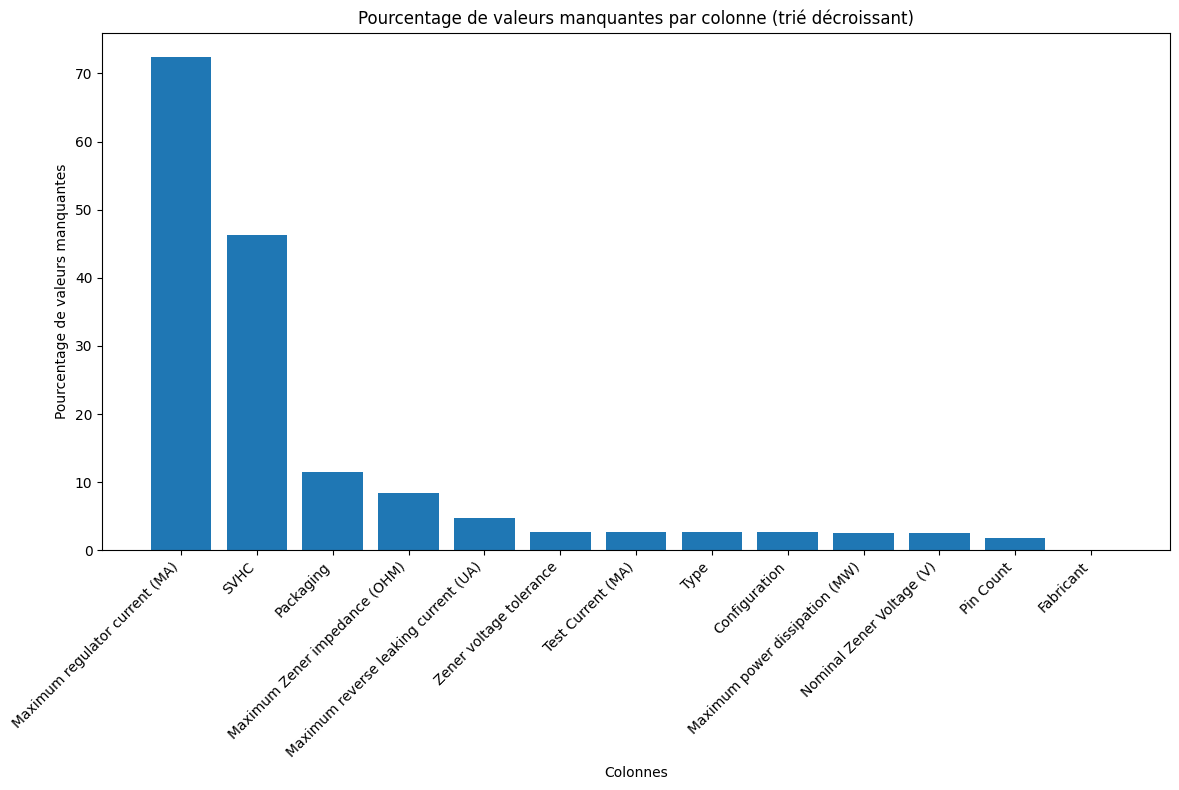

In [262]:
# Dictionnaire des pourcentages de valeurs manquantes
data = { 
   'Fabricant': percentages[0],
   'Type': percentages[1],
   'Configuration': percentages[2],
   'Nominal Zener Voltage (V)': percentages[3],
   'Zener voltage tolerance': percentages[4],
   'Maximum power dissipation (MW)': percentages[5],
   'Test Current (MA)': percentages[6],
   'Maximum reverse leaking current (UA)': percentages[7],
   'Maximum regulator current (MA)': percentages[8],
   'Maximum Zener impedance (OHM)': percentages[9],
   'Packaging': percentages[10],
   'Pin Count': percentages[11],
   'SVHC': percentages[12]
}

# Trier les données en ordre décroissant en fonction des valeurs
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Création du graphique en barres VERTICALES (bar au lieu de barh)
plt.figure(figsize=(12, 8))
plt.bar(list(sorted_data.keys()), list(sorted_data.values()))  # Utilisation de plt.bar pour vertical

# Ajout des labels et du titre
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xlabel('Colonnes')
plt.title('Pourcentage de valeurs manquantes par colonne (trié décroissant)')

# Rotation des étiquettes pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Ajustement automatique de la disposition
plt.tight_layout()

# Affichage du graphique
plt.show()

Les colonnes MA et MW sont à étudier car ils sont assez vide 
Pour la colonne des étiquettes : 46.29% de valeur manquante on va entraîner le modèle dessus

# Nettoyage et Prétaitement des données

In [263]:
df_svhc = df[df['SVHC'] == 1]
df_Nan =  df[df['SVHC'].isna()]
df_nvhc = df[df['SVHC'] == 0]

In [264]:
df_svhc.shape

(1497, 15)

In [265]:
df_nvhc.shape

(2574, 15)

In [266]:
df_Nan.shape


(3509, 15)

In [267]:
df_train = pd.concat([df_svhc, df_nvhc])

In [268]:
df_train


,Reference ZENER,Stock,Fabricant,Type,Configuration,0minal Zener Voltage (V),Zener volatge tolerance,Maximum power dissipation (MW),Test Current (MA),Maximum reverse leaking current (UA),Maximum regulator current (MA),Maximum Zener impedance (OHM),Packaging,Pin Count,SVHC
2,BZX8850S-C1V8YL Zener Diode S1 1.8V 5% 100Ohm ...,NaN,11,V,S1,1.8,5%,365.0,0.05,7.5,NaN,100,7.0,2.0,1.0
4,JANTX1N4614 (DO35) Zener Diode S1 1.8V 5% 1200...,NaN,10,V,S1,1.8,5%,400.0,0.25,7.5,120,1200,2.0,2.0,1.0
32,BZX8850S-C2V0YL Zener Diode S1 2V 5% 100Ohm 36...,NaN,11,V,S1,2.0,5%,365.0,0.05,7.0,NaN,100,7.0,2.0,1.0
33,CD0603-Z2 Zener Diode S1 2V 5% 100Ohm 150mW 2-...,NaN,2,V,S1,2.0,5%,150.0,5.00,100.0,NaN,100,7.0,2.0,1.0
34,CD0603-Z2 Zener Diode S1 2V 5% 100Ohm 150mW 2-...,NaN,2,V,S1,2.0,5%,150.0,5.00,100.0,NaN,100,7.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,SZMMSZ5300T1G DIODE ZENER S1 51V 5% 500MW 2-PI...,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7562,SZMMSZ5300T1G DIODE ZENER S1 51V 5% 500MW 2-PI...,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7563,SZMMSZ5300T1G DIODE ZENER S1 51V 5% 500MW 2-PI...,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7564,SZNZ9F12VT5G Zener Vs 200 mW SOD-923 Surface M...,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,0.0


## Modification des colonnes ayant des données mixtes 

### Dans la colommne "Maximum regulator current (MA)" on a des valeurs de ce type 56@Ta=50C ce qui signifique que le Maximum regulator current est 56 Ma pour une température ambiante de  50°C. On doit prendre que le Ma. Mais on va supprimer la colonne "Maximum regulator current (MA)".

In [269]:
df_train_ss_ref = df_train.drop(columns=['Reference ZENER'])


In [270]:
# Fonction pour extraire la valeur avant '@' ou laisser la valeur d'origine si '@' n'est pas présent
def extract_current_before_at(value):
    if isinstance(value, str) and "@" in value:
        return float(value.split('@')[0])  # Extrait la partie avant '@' comme un float
    return value  # Retourne la valeur d'origine (par ex. : 9.2)

# Fonction pour extraire la température après '@'
def extract_temperature_after_at(value):
    if isinstance(value, str) and "@" in value:
        temp_part = value.split('@')[1].strip()  # Extrait la partie après '@'
        if "=" in temp_part and "C" in temp_part:
            try:
                return float(temp_part.split('=')[1].replace('C', '').strip())  # Extrait la température entre '=' et 'C'
            except ValueError:
                return None  # Retourne None en cas d'erreur
    return None  # Retourne None si '@' n'est pas présent

In [271]:
#test
# Cas de test
print(extract_temperature_after_at("83@Ta=50C"))  # Résultat attendu : 50
print(extract_temperature_after_at("162@Ta=25C"))  # Résultat attendu : 25
print(extract_temperature_after_at("83 @Ta=50C"))  # Résultat attendu : 50 (avec un espace avant @)
print(extract_current_before_at("50"))  # Résultat attendu : 50 (avec un espace après @)


50.0
25.0
50.0
50


In [272]:
# Création de la colonne pour la température ambiante avant de modifier la colonne originale
df_train_ss_ref["Maximum Regulator Current Ambient Temperature (°C)"] = df_train_ss_ref["Maximum regulator current (MA)"].apply(extract_temperature_after_at)

# Mise à jour de la colonne "Maximum regulator current (MA)" pour ne garder que les valeurs avant '@'
df_train_ss_ref["Maximum regulator current (MA)"] = df_train_ss_ref["Maximum regulator current (MA)"].apply(extract_current_before_at)

In [273]:
# Réorganiser les colonnes pour placer "Maximum Regulator Current Ambient Temperature (°C)" après "Maximum regulator current (MA)"
columns = list(df_train_ss_ref.columns)
index = columns.index("Maximum regulator current (MA)")
columns.insert(index + 1, columns.pop(columns.index("Maximum Regulator Current Ambient Temperature (°C)")))
df_train_ss_ref = df_train_ss_ref[columns]

In [274]:
df_train_ss_ref.head()

,Stock,Fabricant,Type,Configuration,0minal Zener Voltage (V),Zener volatge tolerance,Maximum power dissipation (MW),Test Current (MA),Maximum reverse leaking current (UA),Maximum regulator current (MA),Maximum Regulator Current Ambient Temperature (°C),Maximum Zener impedance (OHM),Packaging,Pin Count,SVHC
2,NaN,11,V,S1,1.8,5%,365.0,0.05,7.5,NaN,NaN,100,7.0,2.0,1.0
4,NaN,10,V,S1,1.8,5%,400.0,0.25,7.5,120,NaN,1200,2.0,2.0,1.0
32,NaN,11,V,S1,2.0,5%,365.0,0.05,7.0,NaN,NaN,100,7.0,2.0,1.0
33,NaN,2,V,S1,2.0,5%,150.0,5.00,100.0,NaN,NaN,100,7.0,2.0,1.0
34,NaN,2,V,S1,2.0,5%,150.0,5.00,100.0,NaN,NaN,100,7.0,2.0,1.0


In [275]:
print(df_train_ss_ref["Maximum Regulator Current Ambient Temperature (°C)"].unique())
print(df_train_ss_ref["Maximum regulator current (MA)"].notna().sum())

[ nan  50. 100.]
859


In [276]:
df_train_ss_ref

,Stock,Fabricant,Type,Configuration,0minal Zener Voltage (V),Zener volatge tolerance,Maximum power dissipation (MW),Test Current (MA),Maximum reverse leaking current (UA),Maximum regulator current (MA),Maximum Regulator Current Ambient Temperature (°C),Maximum Zener impedance (OHM),Packaging,Pin Count,SVHC
2,NaN,11,V,S1,1.8,5%,365.0,0.05,7.5,NaN,NaN,100,7.0,2.0,1.0
4,NaN,10,V,S1,1.8,5%,400.0,0.25,7.5,120,NaN,1200,2.0,2.0,1.0
32,NaN,11,V,S1,2.0,5%,365.0,0.05,7.0,NaN,NaN,100,7.0,2.0,1.0
33,NaN,2,V,S1,2.0,5%,150.0,5.00,100.0,NaN,NaN,100,7.0,2.0,1.0
34,NaN,2,V,S1,2.0,5%,150.0,5.00,100.0,NaN,NaN,100,7.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7562,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7563,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7564,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,0.0


### on va enlever les TYP sur la colonne Maximum Zener impedance (OHM)

In [277]:
# extraire les valeurs avant Typ dans la colonne  Maximum Zener impedance (OHM)
def extract_current_before_typ(value):
    if isinstance(value, str) and "(Typ)" in value:
        return float(value.split('(Typ)')[0])  # Extrait la partie avant '(Typ)' comme un float
    return value  # Retourne la valeur d'origine (par ex. : 9.2)


In [278]:
# test 
print(extract_current_before_typ("50(Typ)"))  # Résultat attendu : 50

50.0


In [279]:
df_train_ss_ref["Maximum Zener impedance (OHM)"] = df_train_ss_ref["Maximum Zener impedance (OHM)"].apply(extract_current_before_typ)

df_train_ss_ref["Maximum Zener impedance (OHM)"].unique()

array(['100', '1200', '85', '30', '83', '95', '29', '10', '28', '24', '9',
       '8', '90', '23', '2', '7.5', '15', 23.0, '22', '6', '7', '80',
       22.0, '19', '5', '1550', '78', '60', 19.0, '17', '1.5', nan, '3.5',
       '50', '70', '4', 17.0, '40', '11', '1', '2.5', '25', 11.0, '3',
       '20', 5.0, 6.0, '4.5', '2.3', 8.0, 10.0, '5.5', '6.5', 30.0, '26',
       '13', '14', '16', '32', '36', '12', '45', '42', '55', '58', '17.5',
       '35', '33', '62', 41.0, '44', '49', '65', '88', '75', '38', '130',
       '93', '53', '150', '67', '170', '125', '48', '180', '200', '110',
       '86', '215', '240', '120', '175', '140', '255', '270', '115',
       '400', '250', '350', '750', '450', '300', '225', '380', '190',
       '700', '375', '475', '330', '600', '575', '1000', '550', '1100',
       '625', '650', '430', '900', '800', '480', '500', '1900', '875',
       '1500', '1600', '1050', '2000', '2100', '2300', '2500', '1400',
       '1650', '1700', '21', '10.5', '8.5', '6.6', '5.2', '1

### On va transformer les % de la colonne Zener volatge tolerance

In [280]:
df_train_ss_ref['Zener volatge tolerance'] = df_train_ss_ref['Zener volatge tolerance'].str.replace('%', '').astype(float) / 100

In [281]:
df_train_ss_ref['Zener volatge tolerance'].unique()

array([0.05  , 0.08  , 0.02  , 0.07  , 0.06  , 0.1   , 0.03  , 0.2   ,
          nan, 0.04  , 0.025 , 0.0395, 0.0256, 0.0588, 0.01  , 0.061 ,
       0.0545, 0.0253, 0.0567, 0.0704, 0.0513])

### Transformer les données catégorielles en données numériques de Maximum regulator current (MA) et de  Maximum Zener impedance (OHM)  

#### Transformer les données catégorielles en données numériques de Maximum regulator current (MA)

In [282]:
df_train_ss_ref['Maximum regulator current (MA)'].unique()

array([nan, '120', '454', 252.0, '417', '416', 234.0, '1220', '384',
       '468', '768', 217.0, '1100', '348', '1010', '319', '164', '638',
       '930', 356.0, '520', '356', '588', '196', '865', '267', '432.3',
       '268', 324.0, '480', '179', '324', '790', 146.0, '241', '242',
       292.0, '435', '61', '482', '161', '220', '221', '55', '440', '147',
       '266', '393', '200', '133', '580', '182', 220.0, '45', '122',
       '270.6', '297', '110', '475', '150', '100', '270', 83.0, '430',
       '136', '125', 152.0, '83', '365', '115', '208', '98', '340', '315',
       '180', '132', '67', '169', '93', '114', 50.0, '264', 100.0, '56',
       '70', '75', '90', '50', '68', 82.0, '123', '198', '62', '63', '76',
       '42', '51', '190', '37', '46', '158', '33', '30', '38', '41', '28',
       '69', '26', '31', '34', '32', '29', 36.0, '36', '24', '48', '27',
       '20', '40', '18', 11.0, '58', '52.5', 20.0, 9.0, '47.5', '15',
       '43', '8.6', '25', '12', '22', '36.6', '11', '7', '21'

In [283]:
df_train_ss_ref['Maximum regulator current (MA)'] = pd.to_numeric(
    df_train_ss_ref['Maximum regulator current (MA)'], errors='coerce'
)
df_train_ss_ref['Maximum regulator current (MA)'].unique()

array([   nan,  120. ,  454. ,  252. ,  417. ,  416. ,  234. , 1220. ,
        384. ,  468. ,  768. ,  217. , 1100. ,  348. , 1010. ,  319. ,
        164. ,  638. ,  930. ,  356. ,  520. ,  588. ,  196. ,  865. ,
        267. ,  432.3,  268. ,  324. ,  480. ,  179. ,  790. ,  146. ,
        241. ,  242. ,  292. ,  435. ,   61. ,  482. ,  161. ,  220. ,
        221. ,   55. ,  440. ,  147. ,  266. ,  393. ,  200. ,  133. ,
        580. ,  182. ,   45. ,  122. ,  270.6,  297. ,  110. ,  475. ,
        150. ,  100. ,  270. ,   83. ,  430. ,  136. ,  125. ,  152. ,
        365. ,  115. ,  208. ,   98. ,  340. ,  315. ,  180. ,  132. ,
         67. ,  169. ,   93. ,  114. ,   50. ,  264. ,   56. ,   70. ,
         75. ,   90. ,   68. ,   82. ,  123. ,  198. ,   62. ,   63. ,
         76. ,   42. ,   51. ,  190. ,   37. ,   46. ,  158. ,   33. ,
         30. ,   38. ,   41. ,   28. ,   69. ,   26. ,   31. ,   34. ,
         32. ,   29. ,   36. ,   24. ,   48. ,   27. ,   20. ,   40. ,
      

#### Transformer les données catégorielles en données numériques de Maximum Zener impedance (OHM)

In [284]:
df_train_ss_ref['Maximum Zener impedance (OHM)'] = pd.to_numeric(
    df_train_ss_ref['Maximum Zener impedance (OHM)'], errors='coerce'
)
df_train_ss_ref['Maximum Zener impedance (OHM)'].unique()

array([1.00e+02, 1.20e+03, 8.50e+01, 3.00e+01, 8.30e+01, 9.50e+01,
       2.90e+01, 1.00e+01, 2.80e+01, 2.40e+01, 9.00e+00, 8.00e+00,
       9.00e+01, 2.30e+01, 2.00e+00, 7.50e+00, 1.50e+01, 2.20e+01,
       6.00e+00, 7.00e+00, 8.00e+01, 1.90e+01, 5.00e+00, 1.55e+03,
       7.80e+01, 6.00e+01, 1.70e+01, 1.50e+00,      nan, 3.50e+00,
       5.00e+01, 7.00e+01, 4.00e+00, 4.00e+01, 1.10e+01, 1.00e+00,
       2.50e+00, 2.50e+01, 3.00e+00, 2.00e+01, 4.50e+00, 2.30e+00,
       5.50e+00, 6.50e+00, 2.60e+01, 1.30e+01, 1.40e+01, 1.60e+01,
       3.20e+01, 3.60e+01, 1.20e+01, 4.50e+01, 4.20e+01, 5.50e+01,
       5.80e+01, 1.75e+01, 3.50e+01, 3.30e+01, 6.20e+01, 4.10e+01,
       4.40e+01, 4.90e+01, 6.50e+01, 8.80e+01, 7.50e+01, 3.80e+01,
       1.30e+02, 9.30e+01, 5.30e+01, 1.50e+02, 6.70e+01, 1.70e+02,
       1.25e+02, 4.80e+01, 1.80e+02, 2.00e+02, 1.10e+02, 8.60e+01,
       2.15e+02, 2.40e+02, 1.20e+02, 1.75e+02, 1.40e+02, 2.55e+02,
       2.70e+02, 1.15e+02, 4.00e+02, 2.50e+02, 3.50e+02, 7.50e

### on va créer un nouveau csv pour vérifier que les données ont bien été traitées

In [285]:
# Sauvegarder le fichier mis à jour
updated_file_path_2 = 'C:/Users/scoup/Downloads/updated_arrow_data_lv_with_temperature.csv'
df_train_ss_ref.to_csv(updated_file_path_2, index=False)
updated_file_path_2

'C:/Users/scoup/Downloads/updated_arrow_data_lv_with_temperature.csv'

In [286]:
df_train_ss_ref.head()

,Stock,Fabricant,Type,Configuration,0minal Zener Voltage (V),Zener volatge tolerance,Maximum power dissipation (MW),Test Current (MA),Maximum reverse leaking current (UA),Maximum regulator current (MA),Maximum Regulator Current Ambient Temperature (°C),Maximum Zener impedance (OHM),Packaging,Pin Count,SVHC
2,NaN,11,V,S1,1.8,0.05,365.0,0.05,7.5,NaN,NaN,100.0,7.0,2.0,1.0
4,NaN,10,V,S1,1.8,0.05,400.0,0.25,7.5,120.0,NaN,1200.0,2.0,2.0,1.0
32,NaN,11,V,S1,2.0,0.05,365.0,0.05,7.0,NaN,NaN,100.0,7.0,2.0,1.0
33,NaN,2,V,S1,2.0,0.05,150.0,5.00,100.0,NaN,NaN,100.0,7.0,2.0,1.0
34,NaN,2,V,S1,2.0,0.05,150.0,5.00,100.0,NaN,NaN,100.0,7.0,2.0,1.0


In [287]:
df_train_ss_ref["Maximum Zener impedance (OHM)"].unique()

array([1.00e+02, 1.20e+03, 8.50e+01, 3.00e+01, 8.30e+01, 9.50e+01,
       2.90e+01, 1.00e+01, 2.80e+01, 2.40e+01, 9.00e+00, 8.00e+00,
       9.00e+01, 2.30e+01, 2.00e+00, 7.50e+00, 1.50e+01, 2.20e+01,
       6.00e+00, 7.00e+00, 8.00e+01, 1.90e+01, 5.00e+00, 1.55e+03,
       7.80e+01, 6.00e+01, 1.70e+01, 1.50e+00,      nan, 3.50e+00,
       5.00e+01, 7.00e+01, 4.00e+00, 4.00e+01, 1.10e+01, 1.00e+00,
       2.50e+00, 2.50e+01, 3.00e+00, 2.00e+01, 4.50e+00, 2.30e+00,
       5.50e+00, 6.50e+00, 2.60e+01, 1.30e+01, 1.40e+01, 1.60e+01,
       3.20e+01, 3.60e+01, 1.20e+01, 4.50e+01, 4.20e+01, 5.50e+01,
       5.80e+01, 1.75e+01, 3.50e+01, 3.30e+01, 6.20e+01, 4.10e+01,
       4.40e+01, 4.90e+01, 6.50e+01, 8.80e+01, 7.50e+01, 3.80e+01,
       1.30e+02, 9.30e+01, 5.30e+01, 1.50e+02, 6.70e+01, 1.70e+02,
       1.25e+02, 4.80e+01, 1.80e+02, 2.00e+02, 1.10e+02, 8.60e+01,
       2.15e+02, 2.40e+02, 1.20e+02, 1.75e+02, 1.40e+02, 2.55e+02,
       2.70e+02, 1.15e+02, 4.00e+02, 2.50e+02, 3.50e+02, 7.50e

In [288]:
print(df_train_ss_ref.dtypes)


Stock                                                  object
Fabricant                                               int64
Type                                                   object
Configuration                                          object
0minal Zener Voltage (V)                              float64
Zener volatge tolerance                               float64
Maximum power dissipation (MW)                        float64
Test Current (MA)                                     float64
Maximum reverse leaking current (UA)                  float64
Maximum regulator current (MA)                        float64
Maximum Regulator Current Ambient Temperature (°C)    float64
Maximum Zener impedance (OHM)                         float64
Packaging                                             float64
Pin Count                                             float64
SVHC                                                  float64
dtype: object


# PCA pour voir les principales composantes

## Peut être encoder de manière numérique les colonnes Type et Configuration  

In [289]:
print(df_train_ss_ref.columns.tolist())

['Stock', 'Fabricant', 'Type', 'Configuration', '0minal Zener Voltage (V)', 'Zener volatge tolerance', 'Maximum power dissipation (MW)', 'Test Current (MA)', 'Maximum reverse leaking current (UA)', 'Maximum regulator current (MA)', 'Maximum Regulator Current Ambient Temperature (°C)', 'Maximum Zener impedance (OHM)', 'Packaging', 'Pin Count', 'SVHC']


In [290]:

# Supposons que les colonnes sont nommées "a", "b", ..., "p"
columns = list(df_train_ss_ref.columns)

# Sélection des colonnes de la 5e à l'avant-dernière, sans prendre la 3e et 4e
selected_columns = columns[1:2] + columns[4:-1]  # Exclut la 3e et 4e colonnes
print("Colonnes sélectionnées pour la PCA :", selected_columns)

# Filtrer le DataFrame pour ne garder que les colonnes sélectionnées
df_selected = df_train_ss_ref[selected_columns]

len(df_selected)

Colonnes sélectionnées pour la PCA : ['Fabricant', '0minal Zener Voltage (V)', 'Zener volatge tolerance', 'Maximum power dissipation (MW)', 'Test Current (MA)', 'Maximum reverse leaking current (UA)', 'Maximum regulator current (MA)', 'Maximum Regulator Current Ambient Temperature (°C)', 'Maximum Zener impedance (OHM)', 'Packaging', 'Pin Count']


4071

In [291]:
# Supprimer les lignes contenant des NaN dans les colonnes sélectionnées
df_selected_ss_na = df_selected.dropna()

# Standardiser les données (nécessaire pour la PCA)
df_selected_ss_na_scaled = StandardScaler().fit_transform(df_selected_ss_na)

# Effectuer la PCA
pca = PCA(n_components=2)  # Réduire à 2 dimensions principales
principalComponents = pca.fit_transform(df_selected_ss_na_scaled)

# Créer un DataFrame avec les composantes principales
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])


In [292]:
# Ajouter la colonne target pour les indices correspondants après dropna()
print(principalDf)


    principal component 1  principal component 2
0               -0.962898               4.588855
1               -0.962898               4.588855
2               -0.962898               4.588855
3               -0.957255               3.357333
4               -0.989067               2.355787
5                1.748558              -0.071336
6                1.748558              -0.071336
7                1.748558              -0.071336
8                1.748558              -0.071336
9                1.748558              -0.071336
10               1.748558              -0.071336
11               1.748558              -0.071336
12               1.748558              -0.071336
13               1.748558              -0.071336
14               1.748558              -0.071336
15               1.748558              -0.071336
16               1.748558              -0.071336
17               1.748558              -0.071336
18               1.748558              -0.071336
19               1.7

In [293]:
# Obtenir les charges (importance des colonnes dans les composantes principales)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['Principal Component 1', 'Principal Component 2'],
    index=selected_columns
)

print("Charges des colonnes dans les composantes principales :")
print(loadings)

Charges des colonnes dans les composantes principales :
                                                    Principal Component 1  \
Fabricant                                                       -0.000000   
0minal Zener Voltage (V)                                        -0.443757   
Zener volatge tolerance                                         -0.089914   
Maximum power dissipation (MW)                                   0.332808   
Test Current (MA)                                                0.445224   
Maximum reverse leaking current (UA)                            -0.057914   
Maximum regulator current (MA)                                   0.444105   
Maximum Regulator Current Ambient Temperature (°C)               0.332808   
Maximum Zener impedance (OHM)                                   -0.417930   
Packaging                                                       -0.000000   
Pin Count                                                       -0.000000   

                   

In [294]:
# Identifier les colonnes les plus importantes pour la première composante principale
important_columns_pc1 = loadings['Principal Component 1'].abs().sort_values(ascending=False)
print("Colonnes les plus importantes pour la première composante principale :")
print(important_columns_pc1)

Colonnes les plus importantes pour la première composante principale :
Test Current (MA)                                     0.445224
Maximum regulator current (MA)                        0.444105
0minal Zener Voltage (V)                              0.443757
Maximum Zener impedance (OHM)                         0.417930
Maximum power dissipation (MW)                        0.332808
Maximum Regulator Current Ambient Temperature (°C)    0.332808
Zener volatge tolerance                               0.089914
Maximum reverse leaking current (UA)                  0.057914
Fabricant                                             0.000000
Packaging                                             0.000000
Pin Count                                             0.000000
Name: Principal Component 1, dtype: float64


In [295]:
# Identifier les colonnes les plus importantes pour la première composante principale
important_columns_pc2 = loadings['Principal Component 2'].abs().sort_values(ascending=False)
print("Colonnes les plus importantes pour la première composante principale :")
print(important_columns_pc2)

Colonnes les plus importantes pour la première composante principale :
Maximum reverse leaking current (UA)                  0.553318
Maximum power dissipation (MW)                        0.460271
Maximum Regulator Current Ambient Temperature (°C)    0.460271
Zener volatge tolerance                               0.305569
0minal Zener Voltage (V)                              0.252424
Maximum regulator current (MA)                        0.198907
Test Current (MA)                                     0.196329
Maximum Zener impedance (OHM)                         0.186927
Fabricant                                             0.000000
Packaging                                             0.000000
Pin Count                                             0.000000
Name: Principal Component 2, dtype: float64


In [296]:
print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)
print("Variance totale expliquée :", sum(pca.explained_variance_ratio_))


Variance expliquée par chaque composante : [0.47278629 0.29647131]
Variance totale expliquée : 0.7692575933839365


### Les colonnes Fabricant, Packaging et Pin Count ne sont pas importantes car elles ont une variance de 0 dans PC1 et PC2

In [297]:
df_selected_ss_na
len(df_selected_ss_na)

51

In [298]:
# Colonnes à conserver
important_columns = [
    "Maximum power dissipation (MW)",
    "Maximum Regulator Current Ambient Temperature (°C)",
    "Test Current (MA)",
    "Maximum regulator current (MA)",
    "Maximum reverse leaking current (UA)",
    "0minal Zener Voltage (V)",
    "Maximum Zener impedance (OHM)"
]

# Filtrer le DataFrame et créer une copie explicite
df_final = df_train_ss_ref[important_columns].copy()
#Ajout de la colonne SVHC target 
df_final['SVHC'] = df_train_ss_ref['SVHC']
# Vérification des colonnes restantes
print("Colonnes restantes après réduction :", df_final.columns.tolist())

Colonnes restantes après réduction : ['Maximum power dissipation (MW)', 'Maximum Regulator Current Ambient Temperature (°C)', 'Test Current (MA)', 'Maximum regulator current (MA)', 'Maximum reverse leaking current (UA)', '0minal Zener Voltage (V)', 'Maximum Zener impedance (OHM)', 'SVHC']


In [299]:
df_final

,Maximum power dissipation (MW),Maximum Regulator Current Ambient Temperature (°C),Test Current (MA),Maximum regulator current (MA),Maximum reverse leaking current (UA),0minal Zener Voltage (V),Maximum Zener impedance (OHM),SVHC
2,365.0,NaN,0.05,NaN,7.5,1.8,100.0,1.0
4,400.0,NaN,0.25,120.0,7.5,1.8,1200.0,1.0
32,365.0,NaN,0.05,NaN,7.0,2.0,100.0,1.0
33,150.0,NaN,5.00,NaN,100.0,2.0,100.0,1.0
34,150.0,NaN,5.00,NaN,100.0,2.0,100.0,1.0
...,...,...,...,...,...,...,...,...
7561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Random Forest 


In [300]:


# Supposons que 'SVHC' soit la variable cible
X = df_final[important_columns]
y = df_final['SVHC']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest simple 

In [301]:
# Créer le modèle de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9116564417177914
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       491
         1.0       0.91      0.86      0.89       324

    accuracy                           0.91       815
   macro avg       0.91      0.90      0.91       815
weighted avg       0.91      0.91      0.91       815



# Amélioration du random Forest

Validation croisée (Accuracy moyenne) : 0.9048
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Meilleurs hyperparamètres : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy sur le test : 0.9031
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       491
         1.0       0.92      0.83      0.87       324

    accuracy                           0.90       815
   macro avg       0.91      0.89      0.90       815
weighted avg       0.90      0.90      0.90       815

AUC-ROC Score : 0.9632


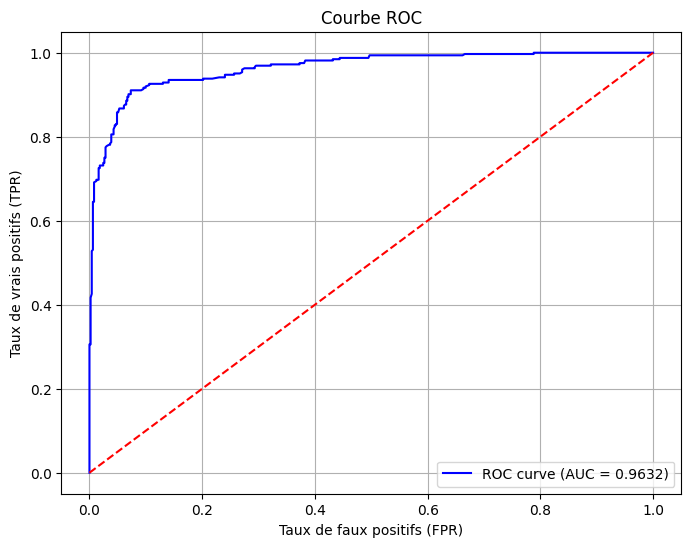

Importance des caractéristiques :
Maximum power dissipation (MW): 0.4913
Maximum reverse leaking current (UA): 0.1224
Maximum Zener impedance (OHM): 0.1169
0minal Zener Voltage (V): 0.1139
Test Current (MA): 0.1007
Maximum regulator current (MA): 0.0546
Maximum Regulator Current Ambient Temperature (°C): 0.0001


In [302]:
# Étape 1 : Création du modèle de Random Forest (avec hyperparamètres de base)
rf_model = RandomForestClassifier(random_state=42)

# Étape 2 : Validation croisée pour évaluer la robustesse du modèle
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Validation croisée (Accuracy moyenne) : {np.mean(cv_scores):.4f}")

# Étape 3 : Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")

# Modèle optimisé
rf_best_model = grid_search.best_estimator_

# Étape 4 : Entraînement du modèle optimisé
rf_best_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = rf_best_model.predict(X_test)
y_pred_proba = rf_best_model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy sur le test : {accuracy:.4f}")
print(f"Rapport de classification :\n{report}")

# Étape 5 : Courbe ROC et AUC
if len(np.unique(y)) == 2:  # Vérification si problème binaire
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    print(f"AUC-ROC Score : {auc_score:.4f}")

    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Étape 6 : Importance des caractéristiques
feature_importances = rf_best_model.feature_importances_
sorted_importances = sorted(zip(important_columns, feature_importances), key=lambda x: x[1], reverse=True)

print("Importance des caractéristiques :")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

# Random Forest

In [303]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Supposons que 'SVHC' soit la variable cible
X = df_train.drop(columns=['SVHC'])
y = df_train['SVHC']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

ValueError: could not convert string to float: 'MMBZ5225B-G3-18 Zener Diode S1 3V 5% 30Ohm 300mW 3-Pin SOT-23 T/R'